In [1]:
from statsmodels.tsa.stattools import adfuller #stationary data checker
from statsmodels.tsa.arima_model import ARIMA #model 
from pmdarima import auto_arima #model optimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# April data from Istanbul

This data was taken from https://data.ibb.gov.tr/tr/dataset/meteorology-observation-station-data-set/resource/9185f819-fba0-4604-b81f-0b5456c23720

The distribution rigths are theirs, this data is not mine.

In [2]:
df = pd.read_csv("./meteorology_observation_202104.csv", index_col='DATE_TIME', parse_dates=True)
df = df.iloc[:,2:5]

In [3]:
df.head()

,MINIMUM_TEMPERATURE,MAXIMUM_TEMPERATURE,AVERAGE_TEMPERATURE
DATE_TIME,,,
2021-04-25 05:00:00,10.20,10.54,10.39917
2021-04-22 21:00:00,11.60,12.30,11.95517
2021-04-27 00:00:00,2.70,3.60,3.27167
2021-04-18 19:00:00,9.33,9.54,9.39846
2021-04-08 05:00:00,4.40,4.70,4.57167


<AxesSubplot:xlabel='DATE_TIME'>

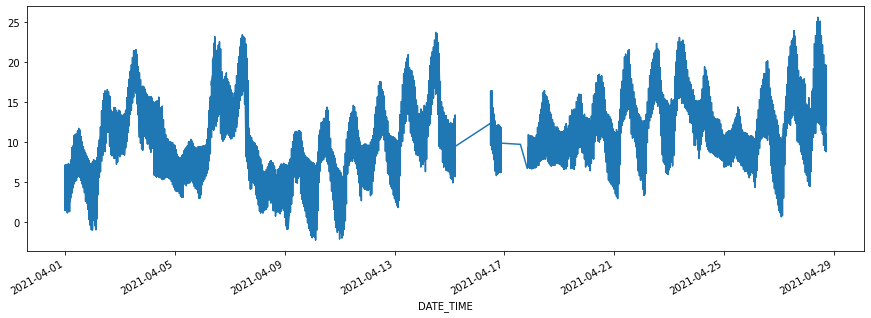

In [5]:
df['AVERAGE_TEMPERATURE'].plot(figsize=(15,5))

This looks stationary but well test it anyway.

In [6]:
adfuller(df['AVERAGE_TEMPERATURE'], autolag='AIC')

(-44.735351068936055,
 0.0,
 19,
 45784,
 {'1%': -3.4304928373814545,
  '5%': -2.861603131061,
  '10%': -2.5668036025981413},
 262939.71329824405)

This function returned in order:
- ADF (the test statistic) = -44.735351068936055
- Pvalue = 0 (as it is less than 0.05 we can be sure that this data is stationary, uses MacKinnon's approximation)
- Number of lags (Fixed amount of passing time = lag, irrelevant.)
- Number of observations used for ADF regression and critical values calculation
- Critical values

Because it is obvious that data is stationary ARIMA doesnt have much use, but we will do it anyway.

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
fit = auto_arima(df['AVERAGE_TEMPERATURE'], trace=True, suppress_warnings=True) #Finds best arima model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=261115.619, Time=7.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=261109.371, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=261110.885, Time=3.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=261110.893, Time=1.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=352455.030, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=261112.867, Time=3.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 16.222 seconds


As we know this is a stationary data, this was expected. All are 0.

In [9]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                45804
Model:                        SARIMAX   Log Likelihood             -131640.657
Date:                Thu, 19 Aug 2021   AIC                         263285.314
Time:                        18:54:45   BIC                         263302.778
Sample:                             0   HQIC                        263290.807
                              - 45804                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.9968      0.020    541.718      0.000      10.957      11.037
sigma2        18.3590      0.132    138.869      0.000      18.100      18.618
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):               499.13
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.22
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
train = df.iloc[:round(-df.shape[0]*80/100)]
test = df.iloc[round(-df.shape[0]*80/100):]

In [11]:
print(train.shape, test.shape)

(9161, 3) (36643, 3)


In [32]:
model = ARIMA(train['AVERAGE_TEMPERATURE'], order=(0,0,0)) #put the values auto_arima found
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     AVERAGE_TEMPERATURE   No. Observations:                 9161
Model:                      ARMA(0, 0)   Log Likelihood              -26298.807
Method:                            css   S.D. of innovations              4.271
Date:                 Thu, 19 Aug 2021   AIC                          52601.613
Time:                         19:00:44   BIC                          52615.858
Sample:                              0   HQIC                         52606.456
                                                                               
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9619      0.045    245.668      0.000      10.874      11.049
==============================================================================
"""

In [33]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ='levels')
pred.index = df.index[start:end+1] #fix indexes to be dates

In [34]:
print(pred) #check if good

DATE_TIME
2021-04-22 01:00:00    10.961862
2021-04-26 12:00:00    10.961862
2021-04-14 09:00:00    10.961862
2021-04-05 08:00:00    10.961862
2021-04-09 13:00:00    10.961862
                         ...    
2021-04-13 22:00:00    10.961862
2021-04-04 19:00:00    10.961862
2021-04-10 19:00:00    10.961862
2021-04-19 17:00:00    10.961862
2021-04-18 17:00:00    10.961862
Length: 36643, dtype: float64


<AxesSubplot:xlabel='DATE_TIME'>

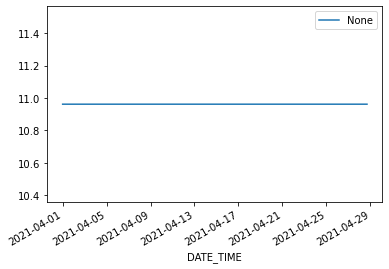

In [35]:
pred.plot(legend=True)